<a href="https://colab.research.google.com/github/Sienna0429/Week-2_Data_Preprocessing/blob/main/merge_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [136]:
# Get the critical imports out of the way
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa.display
import soundfile
import os
# matplotlib complains about the behaviour of librosa.display, so we'll ignore those warnings:
import warnings; warnings.filterwarnings('ignore')
from IPython.core.display import HTML
# Center matplotlib figures...
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
import glob

In [135]:
import os
import re
from google.colab import drive

def convert_emodb_to_target(filename):
    # Use regular expression to parse different parts of the EmoDB filename
    pattern = re.compile(r'(\d{2})([a-z])(\d{2})([A-Za-z])([A-Za-z])\.wav')
    match = pattern.match(filename)

    if match:
        # Extract information from the filename
        speaker_number = match.group(1)
        text_code = match.group(2)
        emotion_code = match.group(3)

        # Handle emotion mapping rules
        emotion_mapping = {'W': '05', 'E': '07', 'A': '06', 'F': '03', 'T': '04', 'N': '01'}
        target_emotion = emotion_mapping.get(emotion_code.upper(), '00')

        # Handle actor mapping rules
        speaker_mapping = {'03': '25', '08': '26', '09': '27', '10': '29', '11': '31',
                           '12': '30', '13': '28', '14': '30', '15': '31', '16': '32'}
        target_actor = speaker_mapping.get(speaker_number, '00')

        # Additional tags
        version_tag = match.group(5) if match.group(5) else '00'  # Version number tag
        sentence_tag = match.group(4) if match.group(4) else '00'  # Sentence tag

        # Remove all lower-case letters from the final filename
        target_filename = f"{version_tag}-{sentence_tag}-{target_emotion}-00-00-00-{target_actor}.wav"

        return target_filename
    else:
        return None

# Set the EmoDB folder path
emo_db_folder = '/content/drive/MyDrive/EMODB'

# Recursively traverse each file in the EmoDB folder, including subfolders
for root, dirs, files in os.walk(emo_db_folder):
    for filename in files:
        if filename.endswith(".wav"):
            # Convert the filename using the defined rules
            converted_filename = convert_emodb_to_target(filename)
            if converted_filename:
                # Rename the file
                original_path = os.path.join(root, filename)
                new_path = os.path.join(root, converted_filename)
                os.rename(original_path, new_path)


In [66]:
import librosa

def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    #print(stft_spectrogram.shape)
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
    #print(chromagram.shape)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=8000).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0)
    return mfc_coefficients

In [92]:
def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)
        feature_matrix=np.array([])

        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))

        return feature_matrix

In [120]:
#Emotions in the merged RAVDESS and EmoDB dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'

}

In [121]:
emotionsE ={
  'W':'angry',
  'F':'happy',
  'T':'sad',
  'E':'disgust',
  'N':'neutral',
  'A':'fearful',
  "L": "boredom"
}

In [ ]:
#gender in the merged RAVDESS and EmoDB dataset
genders={
  '01':'male',
  '02':'female',
  '03':'male',
  '04':'female',
  '05':'male',
  '06':'female',
  '07':'male',
  '08':'female',
  '09':'male',
  '10':'female',
  '11':'male',
  '12':'female',
  '13':'male',
  '14':'female',
  '15':'male',
  '16':'female',
  '17':'male',
  '18':'female',
  '19':'male',
  '20':'female',
  '21':'male',
  '22':'female',
  '23':'male',
  '24':'female'
}

In [ ]:
genderE ={
    '03': 'male',
    '08': 'female',
    '09': 'female',
    '10': 'male',
    '11': 'male',
    '12': 'male',
    '13': 'female',
    '14': 'female',
    '15': 'male',
    '16': 'female'
}

In [140]:
#emotions in E
import os, glob

def load_data():
    X,y=[],[]
    count = 0
    for file in glob.glob("/content/drive/MyDrive/EMODB_1/wav/Actor_*/*.wav"):
        file_name=os.path.basename(file)

        emotion=emotionsE[(file_name[5])]
        #print(emotion)
        features = get_features(file)

        X.append(features)
        y.append(emotion)
        count += 1
        #changing it to 535 because EmoDB has 535 audio samples
        print('\r' + f' Processed {count}/{535} audio samples',end=' ')
    return np.array(X), np.array(y)

In [125]:
featuresE, emotionsE = load_data()

 Processed 535/535 audio samples 

In [148]:
#gender in E
def load_dataGE():
    X,y=[],[]
    count = 0
    for file in glob.glob("/content/drive/MyDrive/EMODB_1/wav/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        #print(file_name)


        #emotion=emotionsE[(file_name[5])]
        gender=genderE[file_name[:2]]
        #print(emotion)
        features = get_features(file)


        X.append(features)
        y.append(gender)
        count += 1
        #changing it to 535 because EmoDB has 535 audio samples
        print('\r' + f' Processed {count}/{535} audio samples',end=' ')
    return np.array(X), np.array(y)

In [144]:
featuresE, genderE = load_dataGE()

 Processed 535/535 audio samples 

In [149]:
#emotion in R
import os, glob

#there are 1440 voice samples in RAVDESS
def load_dataR():
    X,y=[],[]
    count = 0
    for file in glob.glob("/content/drive/MyDrive/Audio_Speech_Actors_01-24/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        #print(file_name)

        emotion=emotions[(file_name.split("-")[2])]
        #print(emotion)
        features = get_features(file)

        X.append(features)
        y.append(emotion)
        count += 1
        #changing it to 535 because ravdess has 1440 vaudio samples
        print('\r' + f' Processed {count}/{1440} audio samples',end=' ')
    return np.array(X), np.array(y)

In [127]:
features, emotions = load_dataR()

 Processed 1435/1440 audio samples 

In [171]:
#gender in R
import os, glob

#there are 1440 voice samples in RAVDESS
def load_dataGR():
    X,y=[],[]
    count = 0
    for file in glob.glob("/content/drive/MyDrive/Audio_Speech_Actors_01-24/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        #print(file_name)

        gender=genders[(file_name.split("-")[6])]
        #print(emotion)
        features = get_features(file)

        X.append(features)
        y.append(gender)
        count += 1
        #changing it to 535 because ravdess has 1440 vaudio samples
        print('\r' + f' Processed {count}/{1440} audio samples',end=' ')
    return np.array(X), np.array(y)

In [172]:
features, genders = load_dataGR()

KeyError: '11.wav'

In [147]:
emotionsberlin = np.delete(emotionsE, emotionsE == 'boredom')
emotions1 = np.delete(emotions, emotions == 'calm')
emotionsr = np.delete(emotions1, emotions1 == 'surprised')

In [129]:
emotionsall = np.concatenate((emotionsr, emotionsberlin))

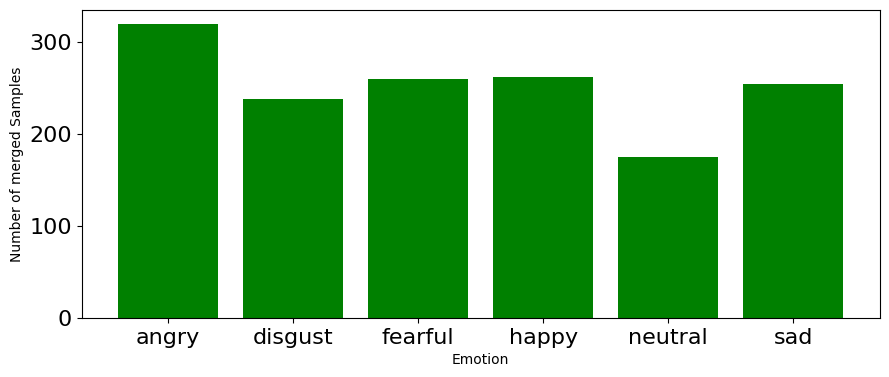

In [165]:
plt.figure(figsize=(35,4))
plt.subplot(1,3,2)
emotion_list, count = np.unique(emotionsall, return_counts=True)
plt.bar(x=range(6), height=count, color = "green")
plt.xticks(ticks=range(6), labels = [emotion for emotion in emotion_list],fontsize=10)
plt.xlabel('Emotion')
plt.tick_params(labelsize=16)
plt.ylabel('Number of merged Samples')
plt.show()
